# LIVE VEGETATION FRACTIONAL COVER ANALYSIS AND MAPPING ROUTINES

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Northern Rangelands Trust-Kenya (NRT) through community conservancies has started supporting community-led grazing management initiatives. To assess the state of rangelands health, NRT in collaboration with the US department of interior developed a toolset requiring the `Modified Soil Adjusted Vegetation Index (MSAVI2)` for monitoring vegetation live fractional cover using publically available Landsat and Sentinel satellite data archives. 

<img src='data/lfcover.PNG'>


## Description

This notebook will produce annual, smoothed, **one-dimensional (zonal mean across a region)** time-series of a remote sensing vegetation indice, such as NDVI or EVI.  In addition, basic phenology statistics are calculated, exported to disk as csv files, and annotated on a plot.

A number of steps are required to produce the desired outputs:

1. Load satellite data for a region specified by an vector file (shapefile or geojson)
2. Buffer the cloud masking layer to better mask clouds in the data (Sentinel-2 cloud mask is quite poor)
3. 
4. Calculate a MSAVI

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import geometry
from matplotlib.colors import ListedColormap
from datacube.utils.cog import write_cog

from odc.algo import xr_geomedian

import sys

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize


from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. For an introduction to using Dask with Digital Earth Africa, see the Dask notebook.

In [2]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:35757' processes=1 threads=2, memory=13.11 GB>

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `product`: The satellite product to load. Either Sentinel-2: `'s2_l2a'`, or Landsat-8: `'ls8_cl2'`
* `shapefile`: The path to the vector file delineating the analysis region. Can be a shapefile or a geojson
* `time_range`: The year range to analyse (e.g. `('2017-01-01', '2019-12-30')`).
* `min_gooddata`: the fraction of good data (not cloudy) a scene must have before it is returned as a dataset 
* `resolution`: The pixel resolution, in metres, of the returned dataset
* `dask_chunks`: The size, in number of pixel, for the dask chunks on each dimension.

In [3]:
veg_proxy = 'MSAVI'

product = 's2_l2a'

shapefile='data/Nalowuon.geojson'

time_range = ('2019-06')

min_gooddata = 0.9

resolution = (-10,10)

dask_chunks = {'time': 1, 'x':2000, 'y':2000}


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='fractional_cover')

## View the region of interest
The next cell will display the selected area on an web map.

In [5]:
#First open the shapefile using geopandas
gdf = gpd.read_file(shapefile)

In [6]:
map_shapefile(gdf, attribute='ConsrvName')

Label(value='')

Map(center=[0.9507290352672665, 37.42911809372548], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

The cell directly below will create a query object using the first geometry in the shapefile, along with the parameters we defined in the Analysis Parameters section above.

In [7]:
# Create a reusable query
geom = geometry.Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)

query = {
    "geopolygon": geom,
    'time': time_range,
    'measurements': ['red','blue','green', 'nir','SCL'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}


Load available data from S2:

In [8]:
ds = load_ard(
    dc=dc,
    products=[product],
#    dask_chunks=dask_chunks,
    min_gooddata=min_gooddata,
    mask_pixel_quality = False,
    **query,
)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 4 out of 6 time steps with at least 90.0% good quality pixels
Loading 4 time steps
<xarray.Dataset>
Dimensions:      (time: 4, x: 3286, y: 4600)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-08T07:59:40 ... 2019-06-28T07:...
  * y            (y) float64 1.443e+05 1.443e+05 ... 9.83e+04 9.828e+04
  * x            (x) float64 3.595e+06 3.595e+06 ... 3.628e+06 3.628e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 663 738 638 848 864 ... 1940 1824 2004 1786
    blue         (time, y, x) uint16 433 465 422 592 628 ... 818 777 731 821 780
    green        (time, y, x) uint16 823 750 775 894 963 ... 1198 1164 1240 1176
    nir          (time, y, x) uint16 3200 2752 2832 3160 ... 2430 2298 2478 2412
    SCL          (time, y, x) uint8 4 4 4 4 4 4 4 4 4 4 ... 5 5 5 5 5 5 5 5 5 5
Attributes:
    crs:           ep

## Cloud Buffering

The cloud masking data for Sentinel-2 is less than perfect, and missed cloud in the data greatly impacts vegetation  calculations. Below we will buffer the cloud-masking bands in an attempt to improve the masking of poor quality data.

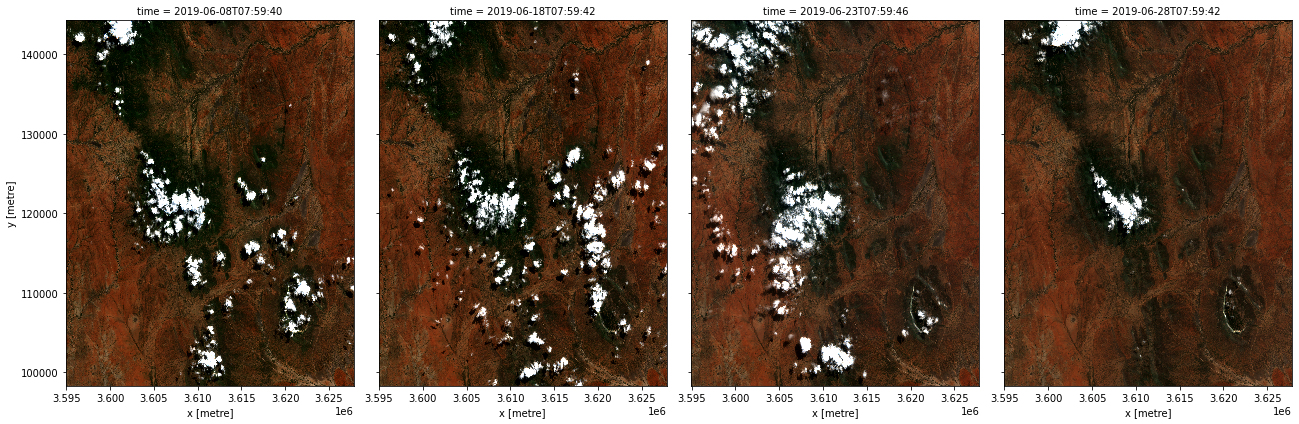

In [9]:
rgb(ds, col='time')

In [10]:
import odc.algo

#Extract boolean mask
mask = odc.algo.enum_to_bool(ds.SCL, 
                             categories=['cloud shadows', 'cloud medium probability',
                                         'cloud high probability', 'thin cirrus'])
                             
# Close mask to remove small holes in cloud, open mask to 
# remove narrow false positive cloud, then dilate
# mask = odc.algo.binary_closing(mask, 2)
mask_cleaned = odc.algo.mask_cleanup(mask, r=(0, 10))

# Add new mask as nodata pixels
ds = odc.algo.erase_bad(ds, mask_cleaned)


In [11]:
# ds = ds.compute()

## Mask the satellite data with shape

In [12]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)

#remove SCL since we don't need it anymore
ds = ds.drop('SCL')

#convert to float 32 to conserve memory
ds=ds.astype(np.float32)

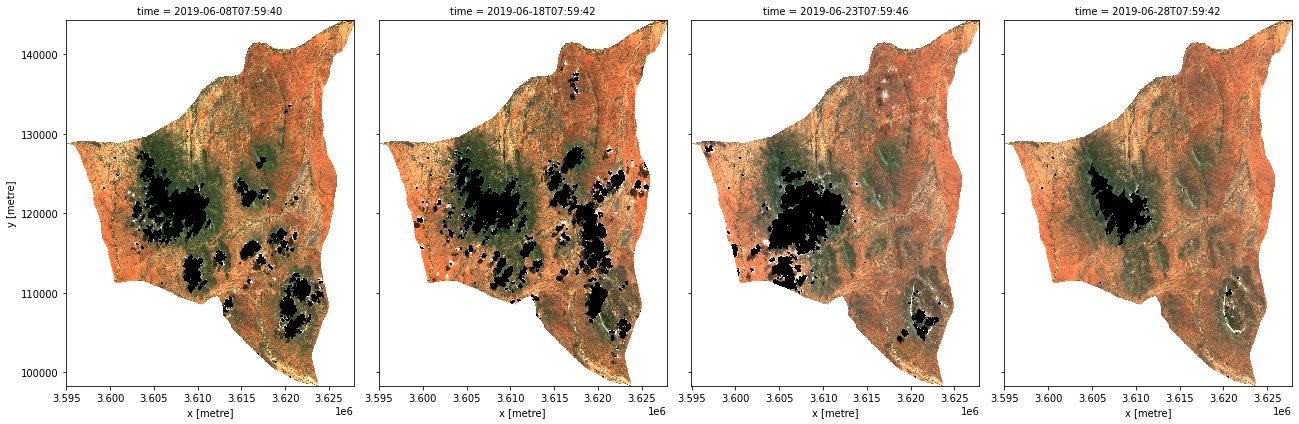

In [13]:
#Display the results and choose the best image for the next cell
rgb(ds, col='time')

In [14]:
#Choose the image to work with
time_index = int(input('Image Index = '))

Image Index =  3


In [15]:
#based on the results show above choose one of the images to use for further analysis
ds = ds.isel(time=time_index)

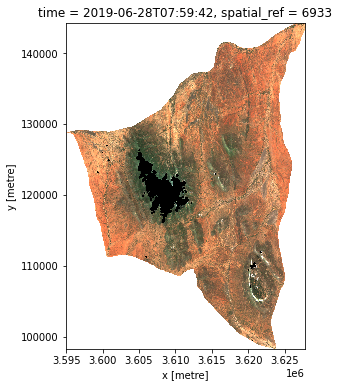

In [16]:
rgb(ds)

## Calculate MSAVI2 and Field MSAVI2 indices

In [17]:
#Multiply red and nir band by 100
ds['red'] = ds['red']  * 100
ds['nir'] = ds['nir'] * 100

In [18]:
def field_MSAVI2(ds):
    return (ds + 0.0018) / 0.877 

def live_veg_frac_cover(ds):
    ds_live = (103.89 * ds) * 2.55
    return ds_live.astype(np.uint8)
    

In [19]:
ds = calculate_indices(ds, index='MSAVI', collection='s2')

In [20]:
# ds_median = ds[['MSAVI']].median(dim='time').compute()

In [21]:
ds['field_MSAVI2'] = field_MSAVI2(ds['MSAVI'])

In [22]:
ds['live_veg_frac_cover'] = live_veg_frac_cover(ds['field_MSAVI2'])

In [23]:
only_ds_fractional_cover =  ds['live_veg_frac_cover'].where(ds['live_veg_frac_cover']>=0.0, np.nan)

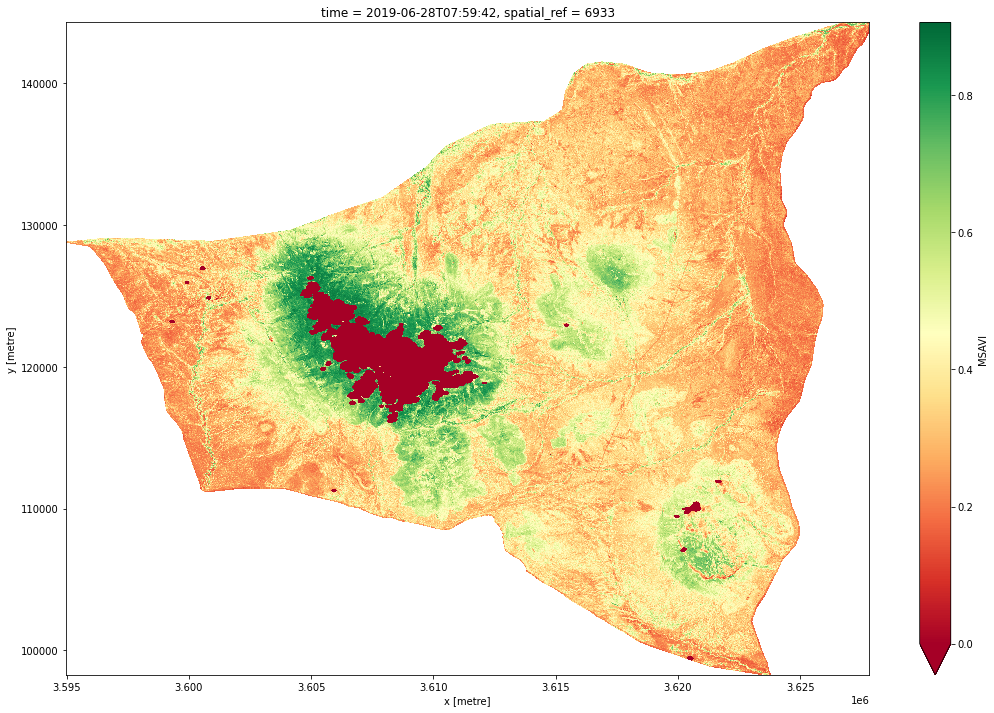

In [24]:
ds['MSAVI'].plot(size=12, cmap='RdYlGn', vmin=0)

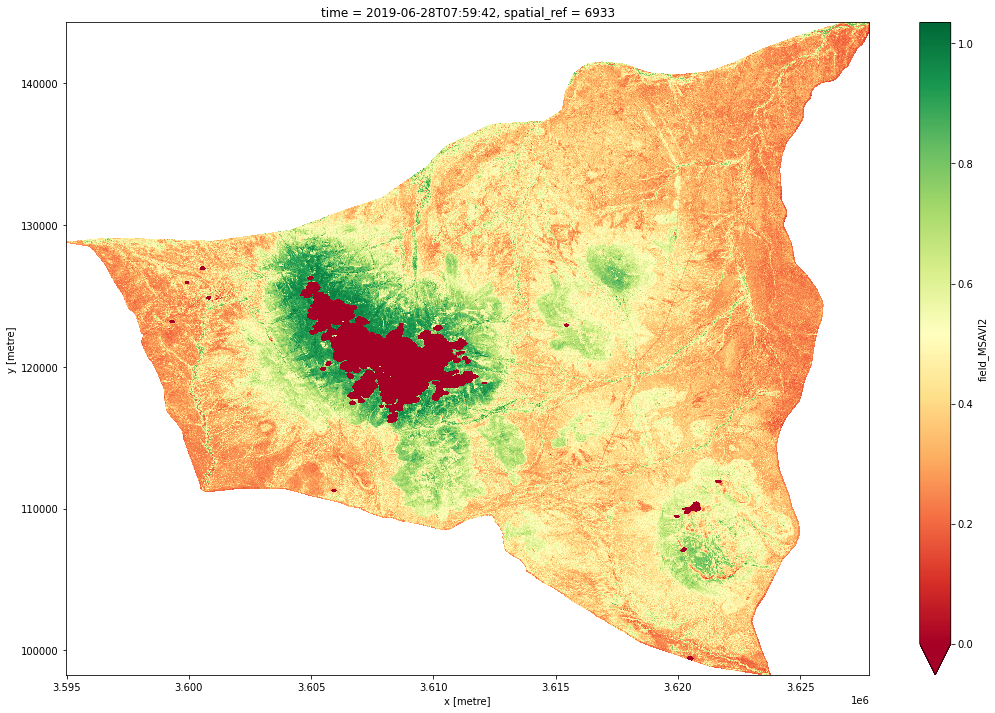

In [25]:
ds['field_MSAVI2'].plot(size=12, cmap='RdYlGn', vmin=0)

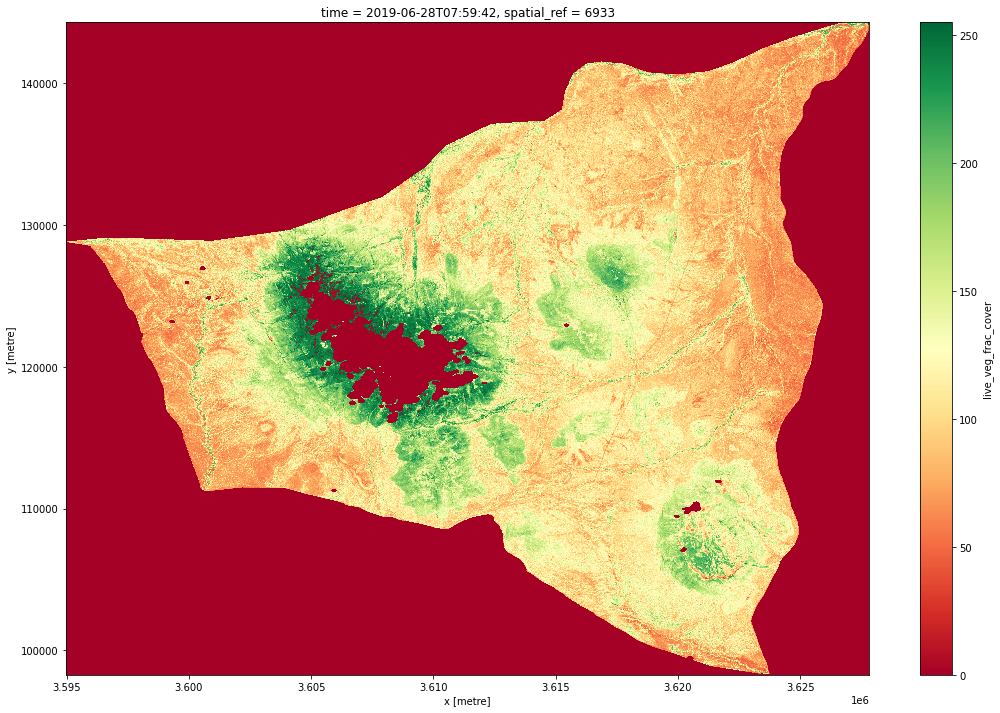

In [26]:
only_ds_fractional_cover.plot(size=12, cmap= 'RdYlGn')

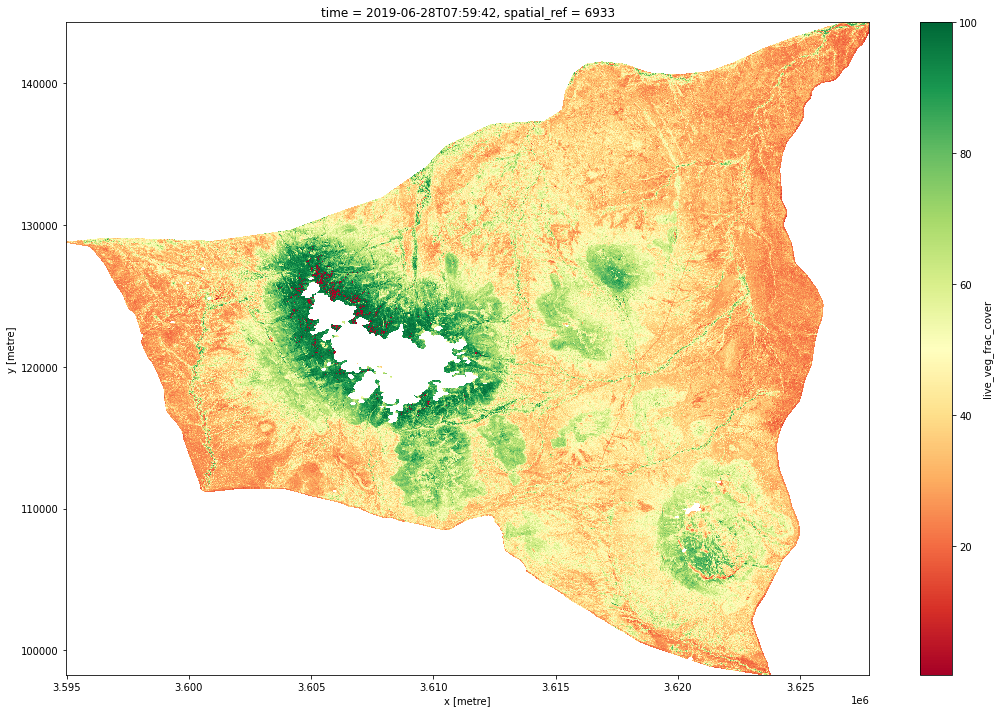

In [27]:
percentage_only_ds_fractional_cover = only_ds_fractional_cover / 2.55
percentage_only_ds_fractional_cover.where(percentage_only_ds_fractional_cover > 0).plot(size=12, cmap= 'RdYlGn')

In [28]:
write_cog(only_ds_fractional_cover,fname='Nalowuon_live_fractional_cover.tif',overwrite=True)
write_cog(percentage_only_ds_fractional_cover,fname='percentage_Nalowuon_live_fractional_cover.tif',overwrite=True)

PosixPath('percentage_Nalowuon_live_fractional_cover.tif')

The basic phenology statistics are summarised in a more readable format below. We can compare the statistics at a high level. Further analysis should be conducted using the .csv exports in the `/results` folder.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [29]:
print(datacube.__version__)

1.8.4.dev193+g3997b90f


**Last Tested:**

In [30]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-07-07'